# 02/16/2024 - This notebook tests the library bin kinematics to see if systematic offset

In [2]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import io
from os import path
import glob
#import Image from PIL
from PIL import Image
import dill as pickle

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from astropy.cosmology import Planck15 as cosmo  # Originally I did Planck 2018, but it seems this one isn't in the version of astropy we have on here and I'm not 
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized


# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
#register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
from slacs_mge_jampy import crop_center_image
from slacs_mge_jampy import import_center_crop
from slacs_mge_jampy import try_fractions_for_find_galaxy
from slacs_mge_jampy import convert_mge_model_outputs
from slacs_mge_jampy import plot_contours_321
from slacs_mge_jampy import plot_contours_531
from slacs_mge_jampy import load_2d_kinematics
from slacs_mge_jampy import bin_velocity_maps
from slacs_mge_jampy import rotate_bins
from slacs_mge_jampy import osipkov_merritt_model
from slacs_mge_jampy import find_half_light
from slacs_mge_jampy import calculate_minlevel
from slacs_mge_jampy import fit_kcwi_sigma_psf
from slacs_mge_jampy import optimize_sigma_psf_fit
from slacs_mge_jampy import estimate_hst_psf
from slacs_mge_jampy import plot_kinematics_mge_contours
from slacs_mge_jampy import get_bin_centers
from slacs_mge_jampy import jampy_details

# slacs_kcwi_kineamtics
from slacs_kcwi_kinematics import slacs_kcwi_kinematics

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC

# specify object directory and name

#################################################
# date and number of initial kinematics run e.g. 2023-02-28_2
date_of_kin = '2024_02_15'
date_of_mge = '2023-02-28_2' # The MGEs I did for these kinematics will still be good. don't need to redo them
###################################################################################################################################

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
# get the revised KCWI sigmapsf
sigmapsf_table = pd.read_csv(f'{tables_dir}kcwi_sigmapsf_estimates.csv')
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
mge_dir = f'{kinematics_full_dir}{date_of_mge}/'
print(f'Outputs will be in {kinematics_dir}')
print()

# target SN for voronoi binning
#vorbin_SN_targets = np.array([10, 15, 20])
vorbin_SN_targets = np.array([15])


#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

Outputs will be in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/kinematics/2024_02_15/



In [3]:
sps_names = ['xshooter','emiles']
vorbin_SN_target = 15
final_plot_size = 3
prolate=False
save=False

In [4]:
sigmas = np.empty((14,2), dtype=object)
dsigmas = np.empty_like(sigmas)

In [5]:
sigmas_safety = np.copy(sigmas)
dsigmas_safety = np.copy(dsigmas)

In [6]:
vs = np.empty_like(sigmas)
dvs = np.empty_like(sigmas)

In [7]:
for j in range(2):
    
    sps_name = sps_names[j]
    
    print('################################################################################################################')
    print('################################################################################################################')
    print()
    print(sps_name)
    print()

    for i in range(len(obj_names)):

        obj_name = obj_names[i]
        obj_abbr = obj_name[4:9]

        print('################################################################################################################')
        print()
        print(obj_name)
        print()

        kin_dir = f'{kinematics_dir}{obj_name}/'

        # get the kinematics from the january date
        with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
            kin_data = pickle.load(file)
        
        # bin kinematics
        V_bin, VD_bin, dV_bin, dVD_bin, chi2_bin = kin_data.bin_kinematics.T
        
        sigmas[i,j] = VD_bin
        dsigmas[i,j] = dVD_bin
        vs[i,j] = V_bin
        dvs[i,j] = dV_bin

        

################################################################################################################
################################################################################################################

xshooter

################################################################################################################

SDSSJ0029-0055

################################################################################################################

SDSSJ0037-0942

################################################################################################################

SDSSJ0330-0020

################################################################################################################

SDSSJ1112+0826

################################################################################################################

SDSSJ1204+0358

################################################################################################################


# Plot sigma_e vs sigma_x

In [8]:
from scipy import stats

In [9]:
from sklearn.linear_model import LinearRegression

In [148]:
sigmas_all_x = np.empty(0)
sigmas_all_e = np.empty(0)
dsigmas_all_x = np.empty(0)
dsigmas_all_e = np.empty(0)

for i in range(14):
    if sigmas_all_e.size != dsigmas_all_e.size:
        print(i)
    sigmas_all_x = np.append(sigmas_all_x, sigmas[i,0])
    sigmas_all_e = np.append(sigmas_all_e, sigmas[i,1])
    dsigmas_all_x = np.append(dsigmas_all_x, dsigmas[i,0])
    dsigmas_all_e = np.append(dsigmas_all_e, dsigmas[i,1])

In [149]:
import statsmodels.api as sm

In [150]:
import scipy

In [151]:
slopes = np.ones(14)

Text(0.5, 0, '$\\sigma_{X}$')

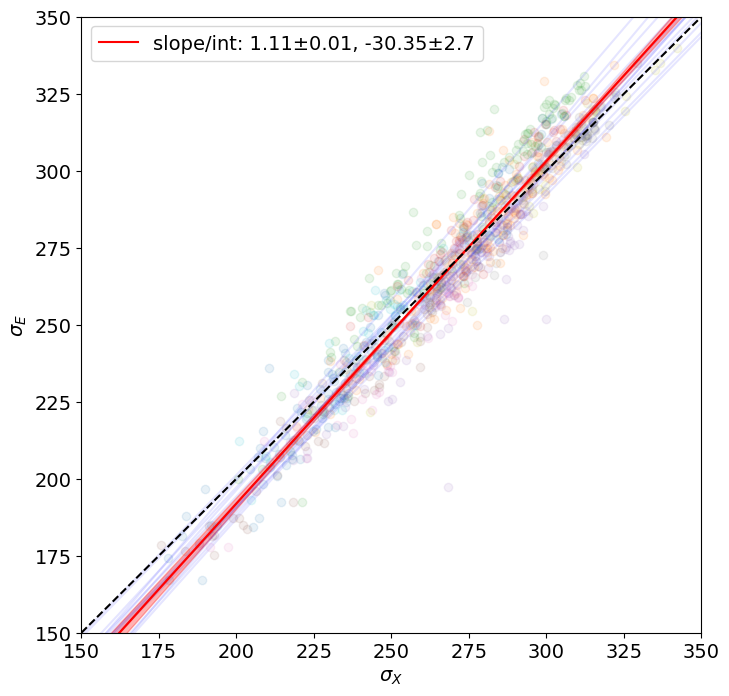

In [152]:
fig, ax = plt.subplots(figsize=(8,8))

# for fitting lines
xx = np.linspace(150, 350, 100)

for i in range(14):
    
    x = np.copy(sigmas[i][0])
    y = np.copy(sigmas[i][1])
    xerr = np.copy(dsigmas[i][0])
    yerr = np.copy(dsigmas[i][1])
    
    if np.nanmax(x) > 350:
        x[np.nanargmax(x)] = np.nan
        y[np.nanargmax(x)] = np.nan
              
    if np.nanmax(y) > 350:
        x[np.nanargmax(y)] = np.nan
        y[np.nanargmax(y)] = np.nan  
    
    result = stats.linregress(x/200, y/200)
    slope = result.slope
    intercept = result.intercept*200
    
    slopes[i] = slope
    
    # fit the datapoints
    ax.scatter(x, y, alpha=0.1)
    
    # fit a line
    yy = intercept + slope*xx
    ax.plot(xx, yy, 'b-', alpha=0.1)
    
# fit a line to all the data
x = np.copy(sigmas_all_x)
y = np.copy(sigmas_all_e)

if np.nanmax(x) > 350:
    ind = np.nanargmax(x)
    x[ind] = np.nan
    y[ind] = np.nan


if np.nanmax(y) > 350:
    ind = np.nanargmax(y)
    x[ind] = np.nan
    y[ind] = np.nan    

xerr = np.copy(dsigmas_all_x)[~np.isnan(x)]
yerr = np.copy(dsigmas_all_e)[~np.isnan(y)]
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

# fit with weights
wsol = sm.WLS(y, sm.add_constant(x), (1/(xerr**2 + yerr**2)) ).fit()

# the estimated coefficient, and its variance
beta, c = wsol.params, wsol.cov_params()
 
# critical value of the t-statistic
N = wsol.nobs
P = wsol.df_model
dof = N - P - 1
z = scipy.stats.t( dof ).ppf(0.84)
 
# the confidence interval
low, hi = beta - z * c, beta + z * c

#plt.fill_between(xx, low[0,0] + low[0,1] * xx, low[1,0] + low[1,1] * xx, color='k', alpha=0.1)
#plt.fill_between(xx, hi[0,0] + hi[0,1] * xx, hi[1,0] + hi[1,1] * xx, color='k', alpha=0.1)

# fit all the datapoints
slope = np.around(wsol.params[1], 2)
slope_err = np.around(np.sqrt(wsol.cov_params().diagonal()[1]), 3)
intercept = np.around(wsol.params[0], 2)
intercept_err = np.around(np.sqrt(wsol.cov_params().diagonal()[0]), 2)

label = f'slope/int: {slope}±{slope_err}, {intercept}±{intercept_err}'
ax.plot(xx, wsol.params[0] + wsol.params[1] * xx, 'r-', alpha=1.0, label=label)
plt.fill_between(xx, 
                 low[0,0] + low[0,1] * xx, 
                 low[1,0] + low[1,1] * xx, 
                 color='r', alpha=0.3)
plt.fill_between(xx, 
                 hi[0,0] + hi[0,1] * xx, 
                 hi[1,0] + hi[1,1] * xx, 
                 color='r', alpha=0.3)

ax.legend()
#ax.scatter(x, y, c='k', marker='.')

ax.plot(xx, xx, 'k--')
ax.set_xlim(150, 350)
ax.set_ylim(150, 350)
ax.set_ylabel(r'$\sigma_{E}$')
ax.set_xlabel(r'$\sigma_{X}$')


(array([0., 5., 2., 1., 1., 2., 0., 1., 1.]),
 array([1.   , 1.025, 1.05 , 1.075, 1.1  , 1.125, 1.15 , 1.175, 1.2  ,
        1.225]),
 <BarContainer object of 9 artists>)

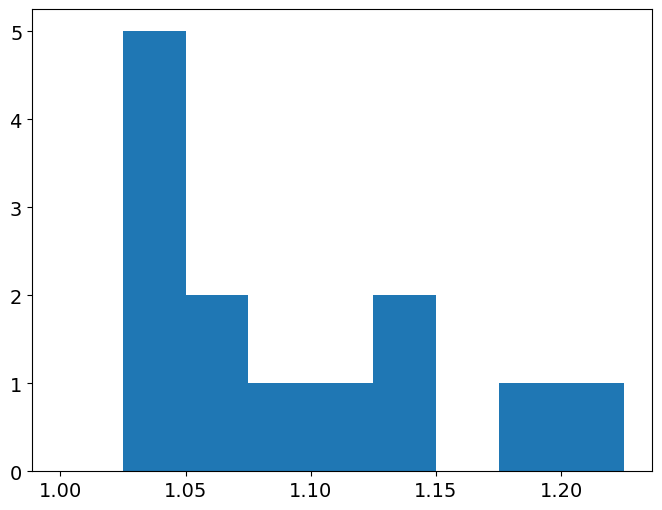

In [15]:
plt.hist(slopes, bins = np.arange(1.0, 1.225, 0.025))

In [16]:
from scipy.optimize import curve_fit

In [17]:
def func(x, c, m):
    return m * (x - 250) + c + 250

result = curve_fit(func, x, y, sigma=np.sqrt(xerr**2 + yerr**2))

In [18]:
result[0]

array([-2.44563288,  1.11161468])

In [19]:
np.sqrt(result[1].diagonal())

array([0.36133965, 0.00980768])

In [20]:
250*(1-result[0][1])-2.44

-30.34367025240892

# 02/19/24 - TT asked me to try the following relation: (sigma_1) = sqrt(sigma_2**2 + a) where a can be positive or negative

In [ ]:
def test_func (x, a):
    
    a = np.ones_like(x) * a

    return np.sqrt( (x - 150)**2 + a ) + 150

In [ ]:
curve_fit(test_func, x, y, sigma=np.sqrt(xerr**2 + yerr**2))

(array([-129.1844193]), array([[4000.6467388]]))

/tmp/ipykernel_57434/881531429.py:5: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt( (x - 150)**2 + a ) + 150


Text(0.5, 0, '$\\sigma_{X}$')

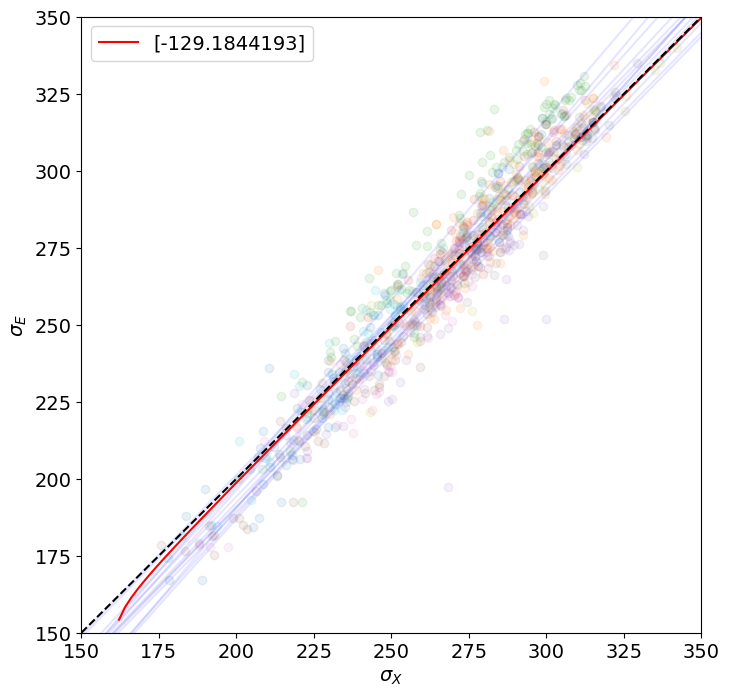

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

# for fitting lines
xx = np.linspace(150, 350, 100)

for i in range(14):
    
    x = np.copy(sigmas[i][0])
    y = np.copy(sigmas[i][1])
    xerr = np.copy(dsigmas[i][0])
    yerr = np.copy(dsigmas[i][1])
    
    if np.nanmax(x) > 350:
        x[np.nanargmax(x)] = np.nan
        y[np.nanargmax(x)] = np.nan
              
    if np.nanmax(y) > 350:
        x[np.nanargmax(y)] = np.nan
        y[np.nanargmax(y)] = np.nan  
    
    result = stats.linregress(x/200, y/200)
    slope = result.slope
    intercept = result.intercept*200
    
    slopes[i] = slope
    
    # fit the datapoints
    ax.scatter(x, y, alpha=0.1)
    
    # fit a line
    yy = intercept + slope*xx
    ax.plot(xx, yy, 'b-', alpha=0.1)
    
# fit a line to all the data
x = np.copy(sigmas_all_x)
y = np.copy(sigmas_all_e)

if np.nanmax(x) > 350:
    ind = np.nanargmax(x)
    x[ind] = np.nan
    y[ind] = np.nan


if np.nanmax(y) > 350:
    ind = np.nanargmax(y)
    x[ind] = np.nan
    y[ind] = np.nan    

xerr = np.copy(dsigmas_all_x)[~np.isnan(x)]
yerr = np.copy(dsigmas_all_e)[~np.isnan(y)]
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

# fit with weights
#wsol = sm.WLS(y, sm.add_constant(x), (1/(xerr**2 + yerr**2)) ).fit()

result = curve_fit(test_func, x, y, sigma=np.sqrt(xerr**2 + yerr**2))
fit = test_func(xx, result[0])

label = f'{result[0]}' #slope/int: {slope}±{slope_err}, {intercept}±{intercept_err}'
ax.plot(xx, fit, 'r-', alpha=1.0, label=label)

ax.legend()
#ax.scatter(x, y, c='k', marker='.')

ax.plot(xx, xx, 'k--')
ax.set_xlim(150, 350)
ax.set_ylim(150, 350)
ax.set_ylabel(r'$\sigma_{E}$')
ax.set_xlabel(r'$\sigma_{X}$')

In [ ]:
xx

array([150.        , 152.02020202, 154.04040404, 156.06060606,
       158.08080808, 160.1010101 , 162.12121212, 164.14141414,
       166.16161616, 168.18181818, 170.2020202 , 172.22222222,
       174.24242424, 176.26262626, 178.28282828, 180.3030303 ,
       182.32323232, 184.34343434, 186.36363636, 188.38383838,
       190.4040404 , 192.42424242, 194.44444444, 196.46464646,
       198.48484848, 200.50505051, 202.52525253, 204.54545455,
       206.56565657, 208.58585859, 210.60606061, 212.62626263,
       214.64646465, 216.66666667, 218.68686869, 220.70707071,
       222.72727273, 224.74747475, 226.76767677, 228.78787879,
       230.80808081, 232.82828283, 234.84848485, 236.86868687,
       238.88888889, 240.90909091, 242.92929293, 244.94949495,
       246.96969697, 248.98989899, 251.01010101, 253.03030303,
       255.05050505, 257.07070707, 259.09090909, 261.11111111,
       263.13131313, 265.15151515, 267.17171717, 269.19191919,
       271.21212121, 273.23232323, 275.25252525, 277.27

In [ ]:
fit

array([149.8253368 , 151.84786258, 153.8703273 , 155.89273335,
       157.91508297, 159.93737832, 161.95962141, 163.98181418,
       166.00395848, 168.02605606, 170.04810857, 172.07011761,
       174.09208469, 176.11401127, 178.13589871, 180.15774833,
       182.1795614 , 184.20133912, 186.22308263, 188.24479305,
       190.26647143, 192.28811877, 194.30973605, 196.33132419,
       198.35288409, 200.37441659, 202.39592253, 204.41740269,
       206.43885782, 208.46028866, 210.4816959 , 212.50308023,
       214.52444227, 216.54578267, 218.56710201, 220.58840089,
       222.60967985, 224.63093944, 226.65218017, 228.67340254,
       230.69460703, 232.71579412, 234.73696424, 236.75811785,
       238.77925534, 240.80037714, 242.82148363, 244.84257518,
       246.86365218, 248.88471497, 250.9057639 , 252.92679929,
       254.94782147, 256.96883076, 258.98982745, 261.01081183,
       263.0317842 , 265.05274482, 267.07369396, 269.09463188,
       271.11555883, 273.13647506, 275.15738079, 277.17

# From Michele: look at the uncorrected velocity dispersions

In [176]:
# here is how I calculated the correction
#print('Resolution of templates is larger than data, correction will be added quadratically to all measured velocity dispersions.')
#sigma_data = c * self.FWHM_data / self.central_wavelength / 2.355
#sigma_temp = c * self.FWHM_templates / self.central_wavelength / 2.355
#sigma_diff2 = (sigma_data**2 - sigma_temp**2)
#self.resolution_difference = sigma_diff2

#------------------------------------------------------------------------------
# Information specific to KCWI and templates
kcwi_scale = 0.1457
## R=3600. spectral resolution is ~ 1.42A
FWHM_data = 1.42 #1.42
## initial estimate of the noise
noise = 0.014
# velocity scale ratio
velscale_ratio = 2
# FWHM of templates
FWHM_xshooter = 0.403 # Angstroms
FWHM_emiles = 2.51 # Angstroms
# central wavelength is where we measure FWHM
central_wavelength = 3950
#------------------------------------------------------------------------------

cc = 299792.458 # km/s


In [177]:
# get corrections for each of the objects based on their redshifts

paper_table = pd.read_csv(f'{tables_dir}paper_table_100223.csv')

In [178]:
zlens = paper_table['zlens'].to_numpy()

In [179]:
#sigma_wrong**2 = sigma_unc**2 + sigma_data**2 - sigma_inst**2
#sigma_correct**2 = sigma_unc**2 + (sigma_data/(1+z))**2 - sigma_inst**2
#so sigma_correct**2 = sigma_wrong**2 + [(1+z)**2 - 1]/(1+z)**2 * sigma_data**2

In [180]:
sigma_data = cc * FWHM_data / central_wavelength / 2.355

corrections = ( (1 + zlens)**2 - 1 ) / (1 + zlens)**2 * sigma_data**2

In [181]:
corrections

array([703.23265496, 627.73364414, 946.87168122, 801.9501185 ,
       548.57653157, 714.50099833, 572.20531259, 651.97424707,
       537.89788394, 491.25595526, 743.16595705, 659.12929743,
       749.65406012, 524.39324015])

In [182]:
np.sqrt(corrections)

array([26.51853418, 25.05461323, 30.77128014, 28.31872381, 23.42171069,
       26.73015148, 23.92081338, 25.53378638, 23.19262564, 22.1642946 ,
       27.26107036, 25.67351354, 27.37981118, 22.89963406])

# Use the properly corrected values.

In [183]:
sigmas_all_x_c = np.empty(0)
sigmas_all_e_c = np.empty(0)
dsigmas_all_x_c = np.empty(0)
dsigmas_all_e_c = np.empty(0)

for i in range(14):
    if sigmas_all_e.size != dsigmas_all_e.size:
        print(i)
    sigmas_all_x_c = np.append(sigmas_all_x_c, sigmas[i,0])
    sigmas_all_e_c = np.append(sigmas_all_e_c, np.sqrt(sigmas[i,1]**2 + (corrections[i]*np.ones_like(sigmas[i,1])) ) )
    dsigmas_all_x_c = np.append(dsigmas_all_x_c, dsigmas[i,0])
    dsigmas_all_e_c = np.append(dsigmas_all_e_c, dsigmas[i,1])

Text(0.5, 0, '$\\sigma_{X}$')

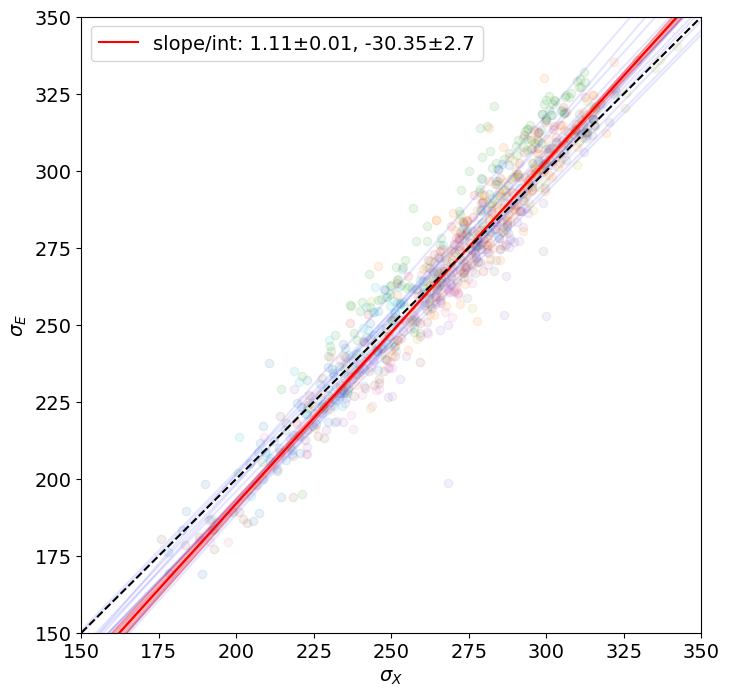

In [184]:
fig, ax = plt.subplots(figsize=(8,8))

# for fitting lines
xx = np.linspace(150, 350, 100)

for i in range(14):
    
    x = np.copy(sigmas[i][0])
    y = np.sqrt(np.copy(sigmas[i][1])**2 + (corrections[i]*np.ones_like(sigmas[i,1])))
    xerr = np.copy(dsigmas[i][0])
    yerr = np.copy(dsigmas[i][1])
    
    if np.nanmax(x) > 350:
        x[np.nanargmax(x)] = np.nan
        y[np.nanargmax(x)] = np.nan
              
    if np.nanmax(y) > 350:
        x[np.nanargmax(y)] = np.nan
        y[np.nanargmax(y)] = np.nan  
    
    result = stats.linregress(x/200, y/200)
    slope = result.slope
    intercept = result.intercept*200
    
    slopes[i] = slope
    
    # fit the datapoints
    ax.scatter(x, y, alpha=0.1)
    
    # fit a line
    yy = intercept + slope*xx
    ax.plot(xx, yy, 'b-', alpha=0.1)
    
# fit a line to all the data
x = np.copy(sigmas_all_x)
y = np.copy(sigmas_all_e)

if np.nanmax(x) > 350:
    ind = np.nanargmax(x)
    x[ind] = np.nan
    y[ind] = np.nan


if np.nanmax(y) > 350:
    ind = np.nanargmax(y)
    x[ind] = np.nan
    y[ind] = np.nan    

xerr = np.copy(dsigmas_all_x_c)[~np.isnan(x)]
yerr = np.copy(dsigmas_all_e_c)[~np.isnan(y)]
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

# fit with weights
wsol = sm.WLS(y, sm.add_constant(x), (1/(xerr**2 + yerr**2)) ).fit()

# the estimated coefficient, and its variance
beta, c = wsol.params, wsol.cov_params()
 
# critical value of the t-statistic
N = wsol.nobs
P = wsol.df_model
dof = N - P - 1
z = scipy.stats.t( dof ).ppf(0.84)
 
# the confidence interval
low, hi = beta - z * c, beta + z * c

#plt.fill_between(xx, low[0,0] + low[0,1] * xx, low[1,0] + low[1,1] * xx, color='k', alpha=0.1)
#plt.fill_between(xx, hi[0,0] + hi[0,1] * xx, hi[1,0] + hi[1,1] * xx, color='k', alpha=0.1)

# fit all the datapoints
slope = np.around(wsol.params[1], 2)
slope_err = np.around(np.sqrt(wsol.cov_params().diagonal()[1]), 3)
intercept = np.around(wsol.params[0], 2)
intercept_err = np.around(np.sqrt(wsol.cov_params().diagonal()[0]), 2)

label = f'slope/int: {slope}±{slope_err}, {intercept}±{intercept_err}'
ax.plot(xx, wsol.params[0] + wsol.params[1] * xx, 'r-', alpha=1.0, label=label)
plt.fill_between(xx, 
                 low[0,0] + low[0,1] * xx, 
                 low[1,0] + low[1,1] * xx, 
                 color='r', alpha=0.3)
plt.fill_between(xx, 
                 hi[0,0] + hi[0,1] * xx, 
                 hi[1,0] + hi[1,1] * xx, 
                 color='r', alpha=0.3)

ax.legend()
#ax.scatter(x, y, c='k', marker='.')

ax.plot(xx, xx, 'k--')
ax.set_xlim(150, 350)
ax.set_ylim(150, 350)
ax.set_ylabel(r'$\sigma_{E}$')
ax.set_xlabel(r'$\sigma_{X}$')


In [185]:
result = curve_fit(func, x, y, sigma=np.sqrt(xerr**2 + yerr**2))

In [186]:
result

(array([-2.44563288,  1.11161468]),
 array([[ 1.30566344e-01, -2.31053537e-03],
        [-2.31053537e-03,  9.61905748e-05]]))

In [187]:
250*(1-result[0][1])-2.44

-30.34367025240892

# Check the wrong ones with the properly corrected ones

(array([  2.,   2.,  15.,  34.,  43.,  88., 123., 224., 296.,  68.]),
 array([-2.44416829, -2.27880641, -2.11344452, -1.94808264, -1.78272076,
        -1.61735888, -1.45199699, -1.28663511, -1.12127323, -0.95591135,
        -0.79054946]),
 <BarContainer object of 10 artists>)

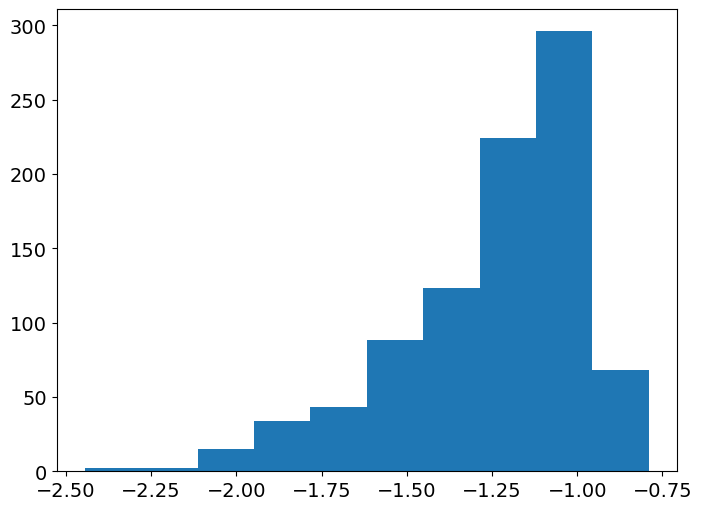

In [157]:
plt.hist(sigmas_all_e - sigmas_all_e_c)

# Now do the uncorrected version

In [188]:
sigma_emiles = cc * FWHM_emiles / central_wavelength / 2.355
#sigma_wrong**2 = sigma_unc**2 - (sigma_data**2 - sigma_inst**2)
sigma_diff_sq = sigma_data**2 - sigma_emiles**2

In [189]:
sigma_diff_sq

-4449.225728922762

In [190]:
sigmas_all_x_u = np.empty(0)
sigmas_all_e_u = np.empty(0)
dsigmas_all_x_u = np.empty(0)
dsigmas_all_e_u = np.empty(0)

for i in range(14):
    if sigmas_all_e.size != dsigmas_all_e.size:
        print(i)
    sigmas_all_x_u = np.append(sigmas_all_x_u, sigmas[i,0])
    sigmas_all_e_u = np.append(sigmas_all_e_u, np.sqrt(sigmas[i,1]**2 + sigma_diff_sq*np.ones_like(sigmas[i,1])) ) 
    dsigmas_all_x_u = np.append(dsigmas_all_x_u, dsigmas[i,0])
    dsigmas_all_e_u = np.append(dsigmas_all_e_u, dsigmas[i,1])

Text(0.5, 0, '$\\sigma_{X}$')

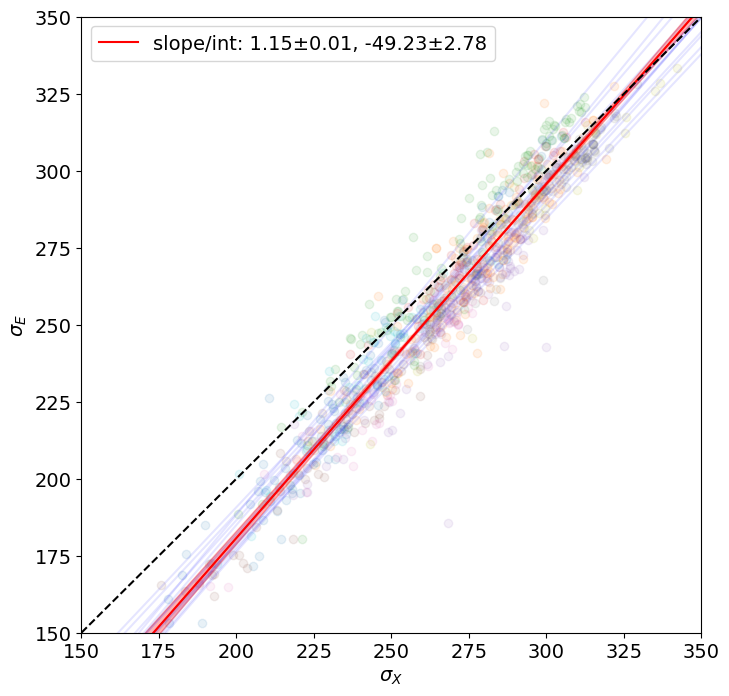

In [191]:
fig, ax = plt.subplots(figsize=(8,8))

# for fitting lines
xx = np.linspace(150, 350, 100)

for i in range(14):
    
    x = np.copy(sigmas[i][0])
    y = np.sqrt(np.copy(sigmas[i][1])**2 + sigma_diff_sq*np.ones_like(sigmas[i,1]))
    xerr = np.copy(dsigmas[i][0])
    yerr = np.copy(dsigmas[i][1])
    
    if np.nanmax(x) > 350:
        x[np.nanargmax(x)] = np.nan
        y[np.nanargmax(x)] = np.nan
              
    if np.nanmax(y) > 350:
        x[np.nanargmax(y)] = np.nan
        y[np.nanargmax(y)] = np.nan  
    
    result = stats.linregress(x/200, y/200)
    slope = result.slope
    intercept = result.intercept*200
    
    slopes[i] = slope
    
    # fit the datapoints
    ax.scatter(x, y, alpha=0.1)
    
    # fit a line
    yy = intercept + slope*xx
    ax.plot(xx, yy, 'b-', alpha=0.1)
    
# fit a line to all the data
x = np.copy(sigmas_all_x_u)
y = np.copy(sigmas_all_e_u)

if np.nanmax(x) > 350:
    ind = np.nanargmax(x)
    x[ind] = np.nan
    y[ind] = np.nan


if np.nanmax(y) > 350:
    ind = np.nanargmax(y)
    x[ind] = np.nan
    y[ind] = np.nan    

xerr = np.copy(dsigmas_all_x_u)[~np.isnan(x)]
yerr = np.copy(dsigmas_all_e_u)[~np.isnan(y)]
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

# fit with weights
wsol = sm.WLS(y, sm.add_constant(x), (1/(xerr**2 + yerr**2)) ).fit()

# the estimated coefficient, and its variance
beta, c = wsol.params, wsol.cov_params()
 
# critical value of the t-statistic
N = wsol.nobs
P = wsol.df_model
dof = N - P - 1
z = scipy.stats.t( dof ).ppf(0.84)
 
# the confidence interval
low, hi = beta - z * c, beta + z * c

#plt.fill_between(xx, low[0,0] + low[0,1] * xx, low[1,0] + low[1,1] * xx, color='k', alpha=0.1)
#plt.fill_between(xx, hi[0,0] + hi[0,1] * xx, hi[1,0] + hi[1,1] * xx, color='k', alpha=0.1)

# fit all the datapoints
slope = np.around(wsol.params[1], 2)
slope_err = np.around(np.sqrt(wsol.cov_params().diagonal()[1]), 3)
intercept = np.around(wsol.params[0], 2)
intercept_err = np.around(np.sqrt(wsol.cov_params().diagonal()[0]), 2)

label = f'slope/int: {slope}±{slope_err}, {intercept}±{intercept_err}'
ax.plot(xx, wsol.params[0] + wsol.params[1] * xx, 'r-', alpha=1.0, label=label)
plt.fill_between(xx, 
                 low[0,0] + low[0,1] * xx, 
                 low[1,0] + low[1,1] * xx, 
                 color='r', alpha=0.3)
plt.fill_between(xx, 
                 hi[0,0] + hi[0,1] * xx, 
                 hi[1,0] + hi[1,1] * xx, 
                 color='r', alpha=0.3)

ax.legend()
#ax.scatter(x, y, c='k', marker='.')

ax.plot(xx, xx, 'k--')
ax.set_xlim(150, 350)
ax.set_ylim(150, 350)
ax.set_ylabel(r'$\sigma_{E}$')
ax.set_xlabel(r'$\sigma_{X}$')


In [192]:
result = curve_fit(func, x, y, sigma=np.sqrt(xerr**2 + yerr**2))

In [193]:
result

(array([-11.73724179,   1.14997372]),
 array([[ 1.38697290e-01, -2.45442267e-03],
        [-2.45442267e-03,  1.02180789e-04]]))

In [194]:
250*(1-result[0][1])-2.44

-39.93343107958835

# Try to fit a correction to it with the test_function

In [212]:
def fit_sigma_correction (x, a):
    
    a = np.ones_like(x) * a

    return np.sqrt( x**2 + a )

In [213]:
fitted_correction = curve_fit(fit_sigma_correction, x, y, sigma=np.sqrt(xerr**2 + yerr**2))

In [214]:
fitted_correction

(array([-4532.83527379]), array([[24800.06461857]]))

In [215]:
np.sqrt(-fitted_correction[0])

array([67.32633418])

In [207]:
sigma_diff_sq

-4449.225728922762

In [234]:
np.sqrt(-sigma_diff_sq)

66.7025166610883

In [208]:
# It's almost exactly like the difference I had.

Text(0.5, 0, '$\\sigma_{X}$')

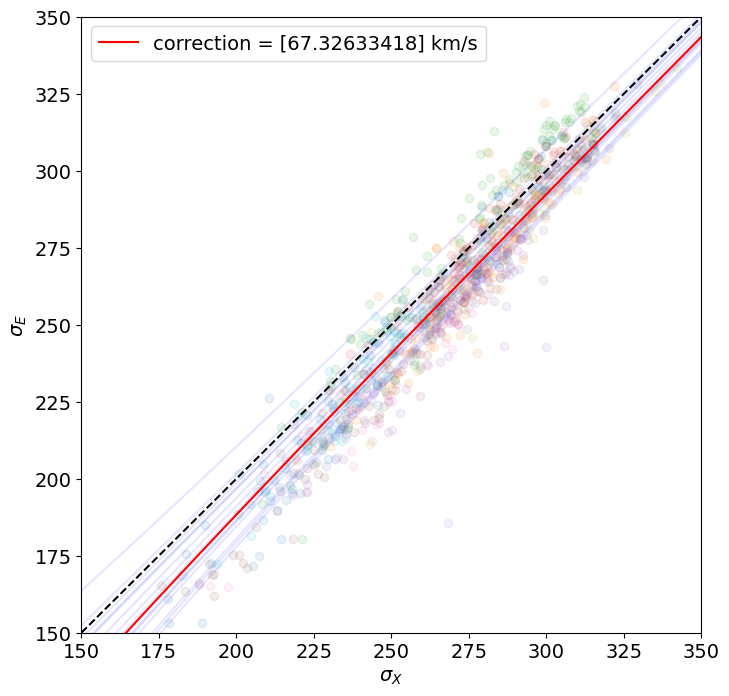

In [233]:
fig, ax = plt.subplots(figsize=(8,8))

# for fitting lines
xx = np.linspace(150, 350, 100)

for i in range(14):
    
    x = np.copy(sigmas[i][0])
    y = np.sqrt(np.copy(sigmas[i][1])**2 + sigma_diff_sq*np.ones_like(sigmas[i,1]))
    xerr = np.copy(dsigmas[i][0])
    yerr = np.copy(dsigmas[i][1])
    
    if np.nanmax(x) > 350:
        argmax = np.nanargmax(x)
        x[argmax] = np.nan
        y[argmax] = np.nan
              
    if np.nanmax(y) > 350:
        argmax = np.nanargmax(y)
        x[argmax] = np.nan
        y[argmax] = np.nan  

    xerr = xerr[~np.isnan(x)]
    yerr = yerr[~np.isnan(y)]
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    
    result = curve_fit(fit_sigma_correction, x, y, sigma=np.sqrt(xerr**2 + yerr**2))
    fit = fit_sigma_correction(xx, result[0])
    # fit the datapoints
    ax.scatter(x, y, alpha=0.1)
    ax.plot(xx, fit, 'b-', alpha=0.1)
    
# fit a line to all the data
x = np.copy(sigmas_all_x_u)
y = np.copy(sigmas_all_e_u)

if np.nanmax(x) > 350:
    ind = np.nanargmax(x)
    x[ind] = np.nan
    y[ind] = np.nan

if np.nanmax(y) > 350:
    ind = np.nanargmax(y)
    x[ind] = np.nan
    y[ind] = np.nan    

xerr = np.copy(dsigmas_all_x)[~np.isnan(x)]
yerr = np.copy(dsigmas_all_e)[~np.isnan(y)]
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

# fit with weights
#wsol = sm.WLS(y, sm.add_constant(x), (1/(xerr**2 + yerr**2)) ).fit()

result = curve_fit(fit_sigma_correction, x, y, sigma=np.sqrt(xerr**2 + yerr**2))
fit = fit_sigma_correction(xx, result[0])

label = f'correction = {np.sqrt(-result[0])} km/s' #slope/int: {slope}±{slope_err}, {intercept}±{intercept_err}'
ax.plot(xx, fit, 'r-', alpha=1.0, label=label)

ax.legend()
#ax.scatter(x, y, c='k', marker='.')

ax.plot(xx, xx, 'k--')
ax.set_xlim(150, 350)
ax.set_ylim(150, 350)
ax.set_ylabel(r'$\sigma_{E}$')
ax.set_xlabel(r'$\sigma_{X}$')

# Get Vrms

In [455]:
vs_safety = np.copy(vs)
dvs_safety = np.copy(dvs)

In [461]:
vs_all_x = np.empty(0)
vs_all_e = np.empty(0)
dvs_all_x = np.empty(0)
dvs_all_e = np.empty(0)

for i in range(14):
    if vs_all_e.size != dvs_all_e.size:
        print(i)
    vs_all_x = np.append(vs_all_x, vs[i,0]-np.nanmedian(vs[i][0]))
    vs_all_e = np.append(vs_all_e, vs[i,1]-np.nanmedian(vs[i][1]))
    dvs_all_x = np.append(dvs_all_x, dvs[i,0])
    dvs_all_e = np.append(dvs_all_e, dvs[i,1])

Text(0.5, 0, '$v_{X}$')

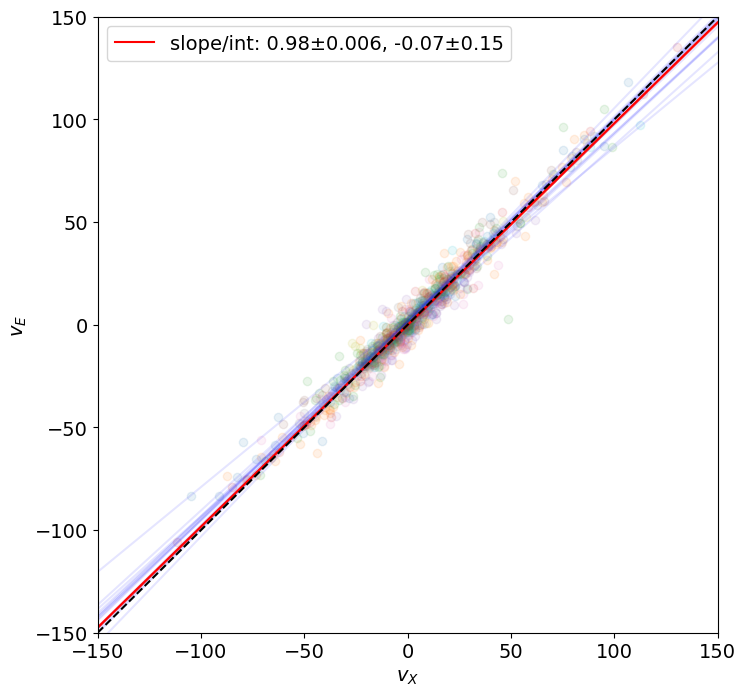

In [463]:
fig, ax = plt.subplots(figsize=(8,8))

# for fitting lines
xx = np.linspace(-150, 150, 100)

for i in range(14):
    
    x = np.copy(vs[i][0]-np.nanmedian(vs[i][0]))
    y = np.copy(vs[i][1]-np.nanmedian(vs[i][1]))
    xerr = np.copy(dvs[i][0])
    yerr = np.copy(dvs[i][1])
    
    if np.nanmax(x) > 350:
        x[np.nanargmax(x)] = np.nan
        y[np.nanargmax(x)] = np.nan
              
    if np.nanmax(y) > 350:
        x[np.nanargmax(y)] = np.nan
        y[np.nanargmax(y)] = np.nan  
    
    result = stats.linregress(x/200, y/200)
    slope = result.slope
    intercept = result.intercept*200
    
    slopes[i] = slope
    
    # fit the datapoints
    ax.scatter(x, y, alpha=0.1)
    
    # fit a line
    yy = intercept + slope*xx
    ax.plot(xx, yy, 'b-', alpha=0.1)
    
# fit a line to all the data
x = np.copy(vs_all_x)
y = np.copy(vs_all_e)

if np.nanmax(x) > 350:
    ind = np.nanargmax(x)
    x[ind] = np.nan
    y[ind] = np.nan


if np.nanmax(y) > 350:
    ind = np.nanargmax(y)
    x[ind] = np.nan
    y[ind] = np.nan    

xerr = np.copy(dvs_all_x)[~np.isnan(x)]
yerr = np.copy(dvs_all_e)[~np.isnan(y)]
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

# fit with weights
wsol = sm.WLS(y, sm.add_constant(x), (1/(xerr**2 + yerr**2)) ).fit()

# the estimated coefficient, and its variance
beta, c = wsol.params, wsol.cov_params()
 
# critical value of the t-statistic
N = wsol.nobs
P = wsol.df_model
dof = N - P - 1
z = scipy.stats.t( dof ).ppf(0.84)
 
# the confidence interval
low, hi = beta - z * c, beta + z * c

#plt.fill_between(xx, low[0,0] + low[0,1] * xx, low[1,0] + low[1,1] * xx, color='k', alpha=0.1)
#plt.fill_between(xx, hi[0,0] + hi[0,1] * xx, hi[1,0] + hi[1,1] * xx, color='k', alpha=0.1)

# fit all the datapoints
slope = np.around(wsol.params[1], 2)
slope_err = np.around(np.sqrt(wsol.cov_params().diagonal()[1]), 3)
intercept = np.around(wsol.params[0], 2)
intercept_err = np.around(np.sqrt(wsol.cov_params().diagonal()[0]), 2)

label = f'slope/int: {slope}±{slope_err}, {intercept}±{intercept_err}'
ax.plot(xx, wsol.params[0] + wsol.params[1] * xx, 'r-', alpha=1.0, label=label)
plt.fill_between(xx, 
                 low[0,0] + low[0,1] * xx, 
                 low[1,0] + low[1,1] * xx, 
                 color='r', alpha=0.3)
plt.fill_between(xx, 
                 hi[0,0] + hi[0,1] * xx, 
                 hi[1,0] + hi[1,1] * xx, 
                 color='r', alpha=0.3)

ax.legend()
#ax.scatter(x, y, c='k', marker='.')

ax.plot(xx, xx, 'k--')
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
ax.set_ylabel(r'$v_{E}$')
ax.set_xlabel(r'$v_{X}$')


In [464]:
Vrms_x = np.sqrt(sigmas_all_x**2 + vs_all_x**2)
Vrms_e = np.sqrt(sigmas_all_e**2 + vs_all_e**2)

Text(0.5, 0, '$v_{X}$')

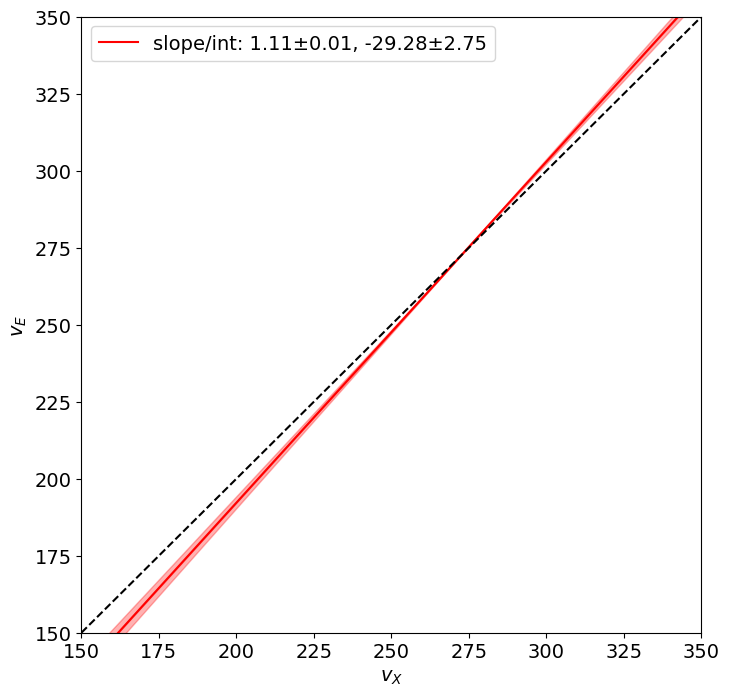

In [467]:
fig, ax = plt.subplots(figsize=(8,8))

# for fitting lines
xx = np.linspace(150, 350, 100)
# fit a line to all the data
x = np.copy(Vrms_x)
y = np.copy(Vrms_e)

if np.nanmax(x) > 350:
    ind = np.nanargmax(x)
    x[ind] = np.nan
    y[ind] = np.nan


if np.nanmax(y) > 350:
    ind = np.nanargmax(y)
    x[ind] = np.nan
    y[ind] = np.nan    

xerr = np.copy(dvs_all_x)[~np.isnan(x)]
yerr = np.copy(dvs_all_e)[~np.isnan(y)]
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

# fit with weights
wsol = sm.WLS(y, sm.add_constant(x), (1/(xerr**2 + yerr**2)) ).fit()

# the estimated coefficient, and its variance
beta, c = wsol.params, wsol.cov_params()
 
# critical value of the t-statistic
N = wsol.nobs
P = wsol.df_model
dof = N - P - 1
z = scipy.stats.t( dof ).ppf(0.84)
 
# the confidence interval
low, hi = beta - z * c, beta + z * c

#plt.fill_between(xx, low[0,0] + low[0,1] * xx, low[1,0] + low[1,1] * xx, color='k', alpha=0.1)
#plt.fill_between(xx, hi[0,0] + hi[0,1] * xx, hi[1,0] + hi[1,1] * xx, color='k', alpha=0.1)

# fit all the datapoints
slope = np.around(wsol.params[1], 2)
slope_err = np.around(np.sqrt(wsol.cov_params().diagonal()[1]), 3)
intercept = np.around(wsol.params[0], 2)
intercept_err = np.around(np.sqrt(wsol.cov_params().diagonal()[0]), 2)

label = f'slope/int: {slope}±{slope_err}, {intercept}±{intercept_err}'
ax.plot(xx, wsol.params[0] + wsol.params[1] * xx, 'r-', alpha=1.0, label=label)
plt.fill_between(xx, 
                 low[0,0] + low[0,1] * xx, 
                 low[1,0] + low[1,1] * xx, 
                 color='r', alpha=0.3)
plt.fill_between(xx, 
                 hi[0,0] + hi[0,1] * xx, 
                 hi[1,0] + hi[1,1] * xx, 
                 color='r', alpha=0.3)

ax.legend()
#ax.scatter(x, y, c='k', marker='.')

ax.plot(xx, xx, 'k--')
ax.set_xlim(150, 350)
ax.set_ylim(150, 350)
ax.set_ylabel(r'$v_{E}$')
ax.set_xlabel(r'$v_{X}$')

In [444]:
fig, ax = plt.subplots(figsize=(8,8))

# for fitting lines
xx = np.linspace(-150, 150, 100)

for i in range(14):
    
    x = np.copy(vs[i][0]-np.nanmedian(vs[i][0]))
    y = np.copy(vs[i][1]-np.nanmedian(vs[i][1]))
    xerr = np.copy(dvs[i][0])
    yerr = np.copy(dvs[i][1])
    
    if np.nanmax(x) > 350:
        x[np.nanargmax(x)] = np.nan
        y[np.nanargmax(x)] = np.nan
              
    if np.nanmax(y) > 350:
        x[np.nanargmax(y)] = np.nan
        y[np.nanargmax(y)] = np.nan  
    
    result = stats.linregress(x/200, y/200)
    slope = result.slope
    intercept = result.intercept*200
    
    slopes[i] = slope
    
    # fit the datapoints
    ax.scatter(x, y, alpha=0.1)
    
    # fit a line
    yy = intercept + slope*xx
    ax.plot(xx, yy, 'b-', alpha=0.1)
    
# fit a line to all the data
x = np.copy(Vrms_all_x)
y = np.copy(Vrms_all_e)

if np.nanmax(x) > 350:
    ind = np.nanargmax(x)
    x[ind] = np.nan
    y[ind] = np.nan


if np.nanmax(y) > 350:
    ind = np.nanargmax(y)
    x[ind] = np.nan
    y[ind] = np.nan    

xerr = np.copy(dvs_all_x)[~np.isnan(x)]
yerr = np.copy(dvs_all_e)[~np.isnan(y)]
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

# fit with weights
wsol = sm.WLS(y, sm.add_constant(x), (1/(xerr**2 + yerr**2)) ).fit()

# the estimated coefficient, and its variance
beta, c = wsol.params, wsol.cov_params()
 
# critical value of the t-statistic
N = wsol.nobs
P = wsol.df_model
dof = N - P - 1
z = scipy.stats.t( dof ).ppf(0.84)
 
# the confidence interval
low, hi = beta - z * c, beta + z * c

#plt.fill_between(xx, low[0,0] + low[0,1] * xx, low[1,0] + low[1,1] * xx, color='k', alpha=0.1)
#plt.fill_between(xx, hi[0,0] + hi[0,1] * xx, hi[1,0] + hi[1,1] * xx, color='k', alpha=0.1)

# fit all the datapoints
slope = np.around(wsol.params[1], 2)
slope_err = np.around(np.sqrt(wsol.cov_params().diagonal()[1]), 3)
intercept = np.around(wsol.params[0], 2)
intercept_err = np.around(np.sqrt(wsol.cov_params().diagonal()[0]), 2)

label = f'slope/int: {slope}±{slope_err}, {intercept}±{intercept_err}'
ax.plot(xx, wsol.params[0] + wsol.params[1] * xx, 'r-', alpha=1.0, label=label)
plt.fill_between(xx, 
                 low[0,0] + low[0,1] * xx, 
                 low[1,0] + low[1,1] * xx, 
                 color='r', alpha=0.3)
plt.fill_between(xx, 
                 hi[0,0] + hi[0,1] * xx, 
                 hi[1,0] + hi[1,1] * xx, 
                 color='r', alpha=0.3)

ax.legend()
#ax.scatter(x, y, c='k', marker='.')

ax.plot(xx, xx, 'k--')
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
ax.set_ylabel(r'$v_{E}$')
ax.set_xlabel(r'$v_{X}$')


array([[array([227.2083654 , 235.32976368, 233.13504449, 233.46337028,
               227.45467667, 237.7020217 , 230.93846114, 231.51354896,
               235.08414214, 241.04923968, 231.93737273, 245.41196844,
               227.51825579, 215.79523231, 208.4944682 , 217.86206911,
               220.60245753, 225.71281632, 235.52846614, 238.95022042,
               234.9521028 , 191.69345619, 213.88297637, 241.77483782,
               229.51096974, 245.53581603, 188.83361079, 207.19244486,
               208.66152912, 206.97984165, 218.13428943, 222.80660274,
               182.48273984, 210.92444825, 233.70772846, 229.66860331,
               234.24770747, 222.40353021, 229.69495068, 205.29621458,
               209.11230847, 220.94212539, 229.65453802, 207.57652048,
               240.88268456, 217.81516763, 219.42496747, 234.31308871,
               213.12009847, 247.51109537, 183.70204532, 224.55989051,
               220.16730874, 212.09462636, 227.88324411, 189.74588745,
      

In [434]:
np.sqrt(result[1].diagonal())*np.array([200,1])

array([2.70143393, 0.00980768])

In [435]:
np.sqrt(wsol.cov_params().diagonal())

array([2.70143388, 0.00980768])

In [436]:
result = stats.linregress(x/200, y/200)
slope = result.slope
intercept = result.intercept*200

In [328]:
slope

1.0897365401825376

In [329]:
intercept

-23.812863145615548

In [326]:
result.intercept_stderr

0.015070348427779053

In [327]:
result.stderr

0.011127478807433984

In [320]:
np.nanmean(slopes)

1.0913761529364636

In [321]:
slopes

array([1.05672016, 1.11634875, 1.17546645, 1.20069936, 1.02908652,
       1.04740804, 1.12510002, 1.05975798, 1.03373998, 1.12971986,
       1.08575834,        nan, 1.03670837])

In [310]:
hi

array([[-0.1418908 ,  1.10563972],
       [-0.14254197,  1.10611062]])

In [267]:
low[0,0]*250

-28.51445241753308

In [159]:
y[np.isnan(y)]

array([nan])

In [157]:
any(np.isnan(y))

True

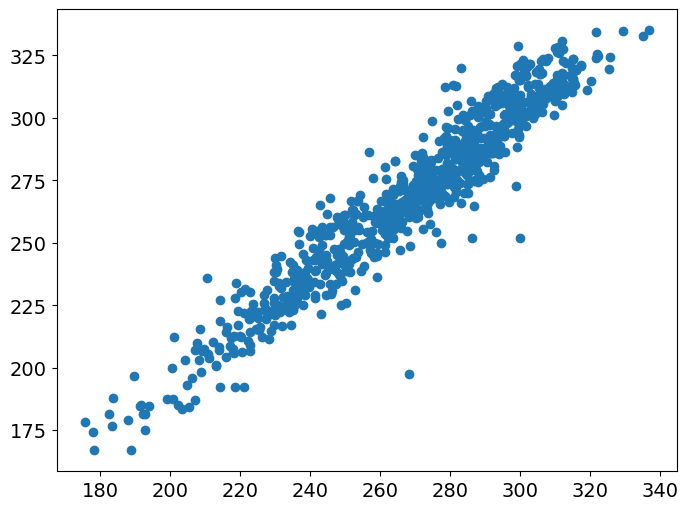

In [121]:
plt.scatter(x, y)

In [141]:
x

array([227.2083654 , 235.32976368, 233.13504449, 233.46337028,
       227.45467667, 237.7020217 , 230.93846114, 231.51354896,
       235.08414214, 241.04923968, 231.93737273, 245.41196844,
       227.51825579, 215.79523231, 208.4944682 , 217.86206911,
       220.60245753, 225.71281632, 235.52846614, 238.95022042,
       234.9521028 , 191.69345619, 213.88297637, 241.77483782,
       229.51096974, 245.53581603, 188.83361079, 207.19244486,
       208.66152912, 206.97984165, 218.13428943, 222.80660274,
       182.48273984, 210.92444825, 233.70772846, 229.66860331,
       234.24770747, 222.40353021, 229.69495068, 205.29621458,
       209.11230847, 220.94212539, 229.65453802, 207.57652048,
       240.88268456, 217.81516763, 219.42496747, 234.31308871,
       213.12009847, 247.51109537, 183.70204532, 224.55989051,
       220.16730874, 212.09462636, 227.88324411, 189.74588745,
       231.92839551, 178.02076419, 214.23214044, 312.60231464,
       310.32034127, 308.44707104, 309.21146222, 287.03

In [105]:
y.shape

(831,)

In [109]:
sigmas_all_x

array([9.88131292e-324, 2.27208365e+002, 2.35329764e+002, 2.33135044e+002,
       2.33463370e+002, 2.27454677e+002, 2.37702022e+002, 2.30938461e+002,
       2.31513549e+002, 2.35084142e+002, 2.41049240e+002, 2.31937373e+002,
       2.45411968e+002, 2.27518256e+002, 2.15795232e+002, 2.08494468e+002,
       2.17862069e+002, 2.20602458e+002, 2.25712816e+002, 2.35528466e+002,
       2.38950220e+002, 2.34952103e+002, 1.91693456e+002, 2.13882976e+002,
       2.41774838e+002, 2.29510970e+002, 2.45535816e+002, 1.88833611e+002,
       2.07192445e+002, 2.08661529e+002, 2.06979842e+002, 2.18134289e+002,
       2.22806603e+002, 1.82482740e+002, 2.10924448e+002, 2.33707728e+002,
       2.29668603e+002, 2.34247707e+002, 2.22403530e+002, 2.29694951e+002,
       2.05296215e+002, 2.09112308e+002, 2.20942125e+002, 2.29654538e+002,
       2.07576520e+002, 2.40882685e+002, 2.17815168e+002, 2.19424967e+002,
       2.34313089e+002, 2.13120098e+002, 2.47511095e+002, 1.83702045e+002,
       2.24559891e+002, 2

In [15]:
sigmas[0]

array([array([227.2083654 , 235.32976368, 233.13504449, 233.46337028,
              227.45467667, 237.7020217 , 230.93846114, 231.51354896,
              235.08414214, 241.04923968, 231.93737273, 245.41196844,
              227.51825579, 215.79523231, 208.4944682 , 217.86206911,
              220.60245753, 225.71281632, 235.52846614, 238.95022042,
              234.9521028 , 191.69345619, 213.88297637, 241.77483782,
              229.51096974, 245.53581603, 188.83361079, 207.19244486,
              208.66152912, 206.97984165, 218.13428943, 222.80660274,
              182.48273984, 210.92444825, 233.70772846, 229.66860331,
              234.24770747, 222.40353021, 229.69495068, 205.29621458,
              209.11230847, 220.94212539, 229.65453802, 207.57652048,
              240.88268456, 217.81516763, 219.42496747, 234.31308871,
              213.12009847, 247.51109537, 183.70204532, 224.55989051,
              220.16730874, 212.09462636, 227.88324411, 189.74588745,
              231.92

In [ ]:
#squash